# Bayesian Judging
### Eric Miller, Olin College

The [Gavel](https://github.com/anishathalye/gavel) expo judging system, as used at HackMIT, HackHarvard, and many other hackathons, is based on asking judges to perform pairwise comparisons of different teams. The algorithm it uses is based on the CrowdBT algorithm defined  and developed in [this paper](http://people.stern.nyu.edu/xchen3/images/crowd_pairwise.pdf), and is effectively a maximum likelihood estimate for the ranking of entries using a slightly modified version of the Bradley-Terry model for pairwise comparisons. This results in a global ranking of the goodness of all teams, despite the fact that no judge has seen all teams and no team has been seen by all judges.

<img width="50%" src="https://www.anishathalye.com/media/2015/03/07/adjacency-graph.png"/>


Unfortunately, Gavel is based on a single estimate of the maximum likelihood ranking, it is unable to answer the question of with what _confidence_ that ranking is correct. Using data from the  rookie division of the 2015 Blueprint hackathon, I implemented a Bayesian algorithm in [pymc3](https://docs.pymc.io/) inspired by CrowdBT that uses the available pairwise comparison data to determine which team at the hackathon had the best project, and with what probability they are the best.

In [59]:
import numpy as np
import itertools

import pandas as pd
import pymc3 as pm
from thinkbayes2 import Pmf, Cdf, Suite, Joint, MakeJoint, MakeMixture, MakeNormalPmf, Beta
import thinkplot

# Modelling Comparisons

In a classical Bradley-Terry model, each team is represented by a single number $\beta_i$ where the probability that a judge ranks $i>j$ is 

$$P(i > j) = \frac{e^{\beta_i}}{e^{\beta_i} + e^{\beta_j}}$$

[source](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model)

This model treats all judges as being identical, which is not an accurate assumption in an expo environment, so we extend this model with an extra term $p_x$ for each judge, representing the probability that this specific judge will "tell the truth" about a comparison they are assessing.

$$P(i > j | x) = p_x * \frac{e^{\beta_i}}{e^{\beta_i} + e^{\beta_j}} + (1-p_x) * \frac{e^{\beta_j}}{e^{\beta_i} + e^{\beta_j}}$$

I implemented this function using both ThinkBayes grid algorithms and PyMC3

In [10]:
def prob_wins_grid(winner_score, loser_score, judge_score):
    p_bt = np.exp(winner_score) / (np.exp(winner_score)+np.exp(loser_score))
    return judge_score * p_bt + (1-judge_score) * (1-p_bt)

from pymc3.math import exp

def prob_wins_mc(winner, loser, judge, identifier):
    p_bt = exp(winner) / (exp(loser)+exp(winner))
    return pm.Binomial(f'judging_result_{identifier}', n=1, 
                p=judge * p_bt + (1-judge) * (1-p_bt), observed=1)

## Implementation using grid algorithms

Here, I implement a trivial 2-team tournament with a single judge.

In [11]:
class Tournament(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        hypo is a tuple of lists (list of the scores of all teams, list of scores of judges)
        """
        judge, winner, loser = data
        teams, judges = hypo
        
        return prob_wins_grid(teams[winner], teams[loser], judges[judge])

In [12]:
def MakeJointMany(dist, n):
    """MakeJointMany returns a joint distribution of n copies of dist"""
    pmf = Pmf()
    for vals in itertools.product(dist.Items(), repeat=n):
        pmf.Incr(tuple([val for val, p in vals]), np.product([p for val, p in vals]))
    return pmf

Mean for team 0: -1.80
Mean for team 1: 1.80


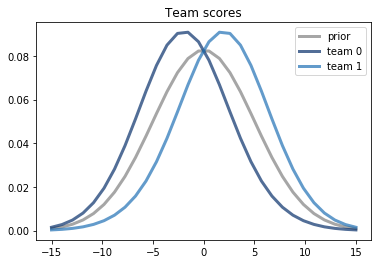

Mean for judge 0: 0.83


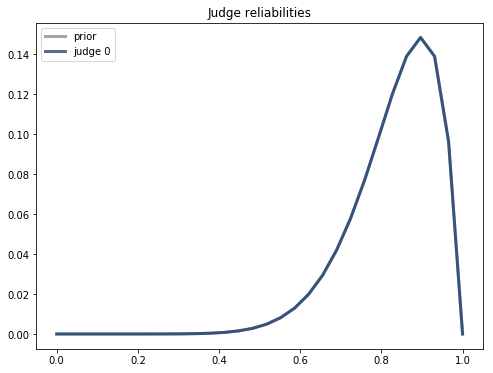

<Figure size 576x432 with 0 Axes>

In [45]:
num_teams = 2
num_judges = 1
team_prior = MakeNormalPmf(mu=0, sigma=5, num_sigmas=3, n=30)
judge_prior = Beta(10, 2).MakePmf(30)

tournament = Tournament(MakeJoint(MakeJointMany(team_prior, num_teams), 
                             MakeJointMany(judge_prior, num_judges)))

# Judge 0 ranks team 1 > team 0
tournament.Update((0, 1, 0))

# Plot the output
thinkplot.Pdf(team_prior, label='prior', color='grey')
for i in range(num_teams):
    marginal = Joint(tournament.Marginal(0)).Marginal(i)
    thinkplot.Pdf(marginal, label=f'team {i}')
    print(f"Mean for team {i}: {marginal.Mean():.2f}")
thinkplot.Config(title='Team scores')
thinkplot.Show()

thinkplot.Pdf(judge_prior, label='prior', color='grey')
for i in range(num_judges):
    marginal = Joint(tournament.Marginal(1)).Marginal(i)
    thinkplot.Pdf(marginal, label=f'judge {i}')
    print(f"Mean for judge {i}: {marginal.Mean():.2f}")
thinkplot.Config(title='Judge reliabilities')
thinkplot.Show()

In this case, it is simple to observe that the vote of the judge increases the expected value of the team they thought was better, and decreases the value of the team they thought is worse. Because there are no other judges to compare them with, their own reliability rating is unaffected.

## Trivial example using MCMC

In [48]:
num_teams = 2
num_judges = 1

with pm.Model() as model:
    teams = {}
    for i in range(num_teams):
        teams[i] = pm.Normal(f't_{i}', mu=0, sd=5)
    
    judges = {}
    for i in range(num_judges):
        judges[i] = pm.Beta(f'j_{i}', alpha=10, beta=2)

    prob_wins_mc(teams[1], teams[0], judges[0], 0)

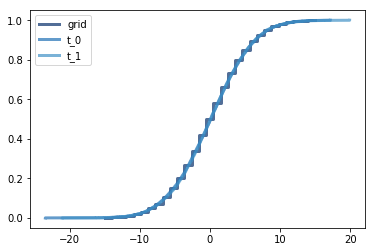

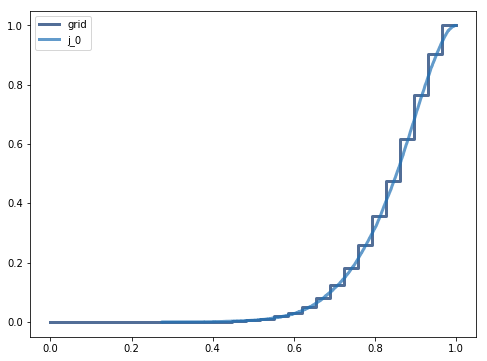

Team 1 wins 50.19% of rematches


<Figure size 576x432 with 0 Axes>

In [57]:
## Validate prior
with model:
    trace_prior = pm.sample_prior_predictive(10000)

thinkplot.Cdf(team_prior.MakeCdf(), label='grid')
for i in teams:
    thinkplot.Cdf(Cdf(trace_prior[f't_{i}']), label=f't_{i}')
thinkplot.Config()
thinkplot.Show()

thinkplot.Cdf(judge_prior.MakeCdf(), label='grid')
for i in judges:
    thinkplot.Cdf(Cdf(trace_prior[f'j_{i}']), label=f'j_{i}')
thinkplot.Config()
thinkplot.Show()

print(f"Team 1 wins {100*np.mean(trace_prior['judging_result_0'] == 1):.2f}% of rematches")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [j_0, t_1, t_0]
Sampling 2 chains: 100%|██████████| 6600/6600 [00:05<00:00, 1168.54draws/s]


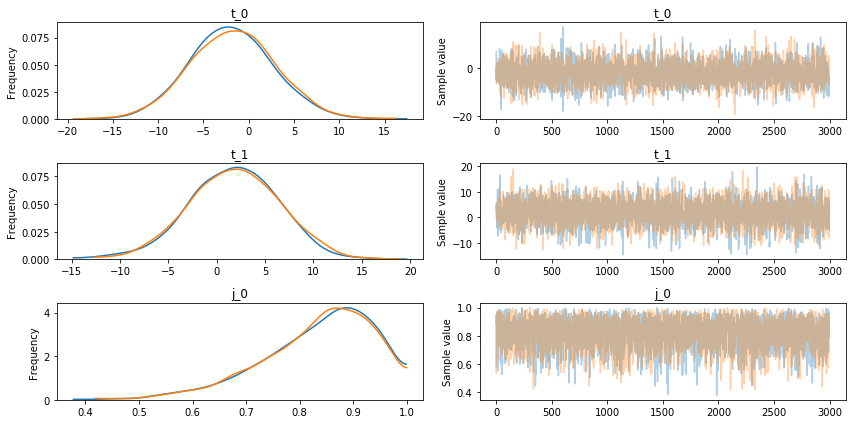

In [52]:
## Compute posterior

with model:
    trace = pm.sample(3000, tune=300)
    
pm.traceplot(trace);

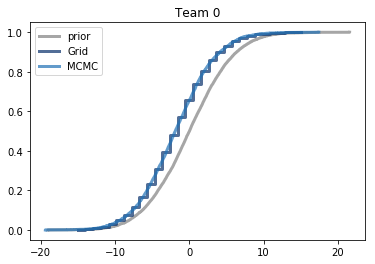

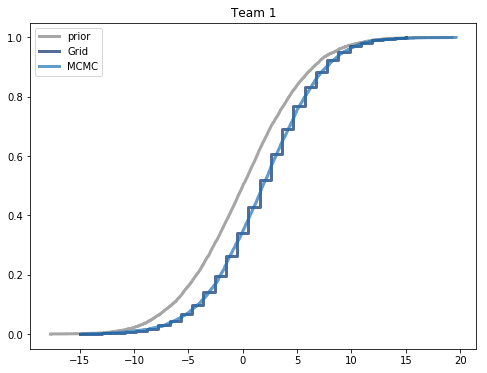

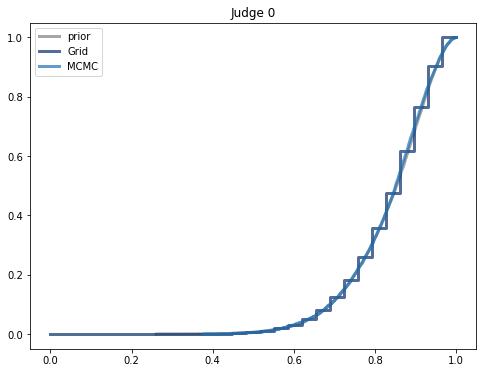

<Figure size 576x432 with 0 Axes>

In [56]:
for i in range(num_teams):
    thinkplot.Cdf(Cdf(trace_prior[f"t_{i}"]), label='prior', color='grey')
    
    marginal = Joint(tournament.Marginal(0)).Marginal(i)
    thinkplot.Cdf(marginal.MakeCdf(), label=f'Grid')
    
    thinkplot.Cdf(Cdf(trace[f"t_{i}"]), label='MCMC')
    
    thinkplot.Config(title=f"Team {i}")
    thinkplot.Show()

for i, _ in enumerate(judges):
    thinkplot.Cdf(Cdf(trace_prior[f"j_{i}"]), label='prior', color='grey')
    
    marginal = Joint(tournament.Marginal(1)).Marginal(i)
    thinkplot.Cdf(marginal.MakeCdf(), label=f'Grid')
    
    thinkplot.Cdf(Cdf(trace[f"j_{i}"]), label='MCMC')
    thinkplot.Config(title=f"Judge {i}")
    thinkplot.Show()


This validation demonstrates that the MCMC algorithm does actually perform the same as the grid algorithm, at least on this small sample case.

# Extending to real data

Here, I load the actual data from the Blueprint rookie division. Because there is no judge identity data contained in this dataset, all rankings are taken to be from a single judge named 'na'. Note that this dataset contains approximately 240 comparisons, and so it may take several minutes to run these cells.

In [60]:
data = list(pd.read_csv('../data/blueprint-rookie-data.csv').itertuples())

In [62]:
def make_model(data):
    """
    data is a list of named tuples containing "annotator", "loser", and "winner" elements
    """
    with pm.Model() as model:
        teams = {}
        for i in set((r.winner for r in data)).union(set((r.loser for r in data))):
            teams[i] = pm.Normal(f't_{i}', mu=0, sd=5)

        judges = {}
        for i in set((r.annotator for r in data)):
            judges[i] = pm.Beta(f'j_{i}', alpha=10, beta=2)

        for i, r in enumerate(data):
            prob_wins_mc(teams[r.winner], teams[r.loser], judges[r.annotator], i)
        
    return model, judges, teams

model, judges, teams = make_model(data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [j_na, t_26e4, t_c0d7, t_2845, t_1a2a, t_9f2b, t_e212, t_70ef, t_d2a6, t_762c, t_91b2, t_945d, t_3c11, t_dc8e, t_ecba, t_75f9, t_96b9, t_c096, t_60fb, t_17a9, t_21d7, t_a46f, t_eb0e, t_ffef, t_a4ec, t_b568, t_0965, t_0325, t_fb8d, t_3f1b, t_70ff, t_0815, t_6500, t_dc51, t_f717, t_bbdd, t_da90, t_a4d8]
Sampling 2 chains: 100%|██████████| 2600/2600 [02:18<00:00, 18.74draws/s]


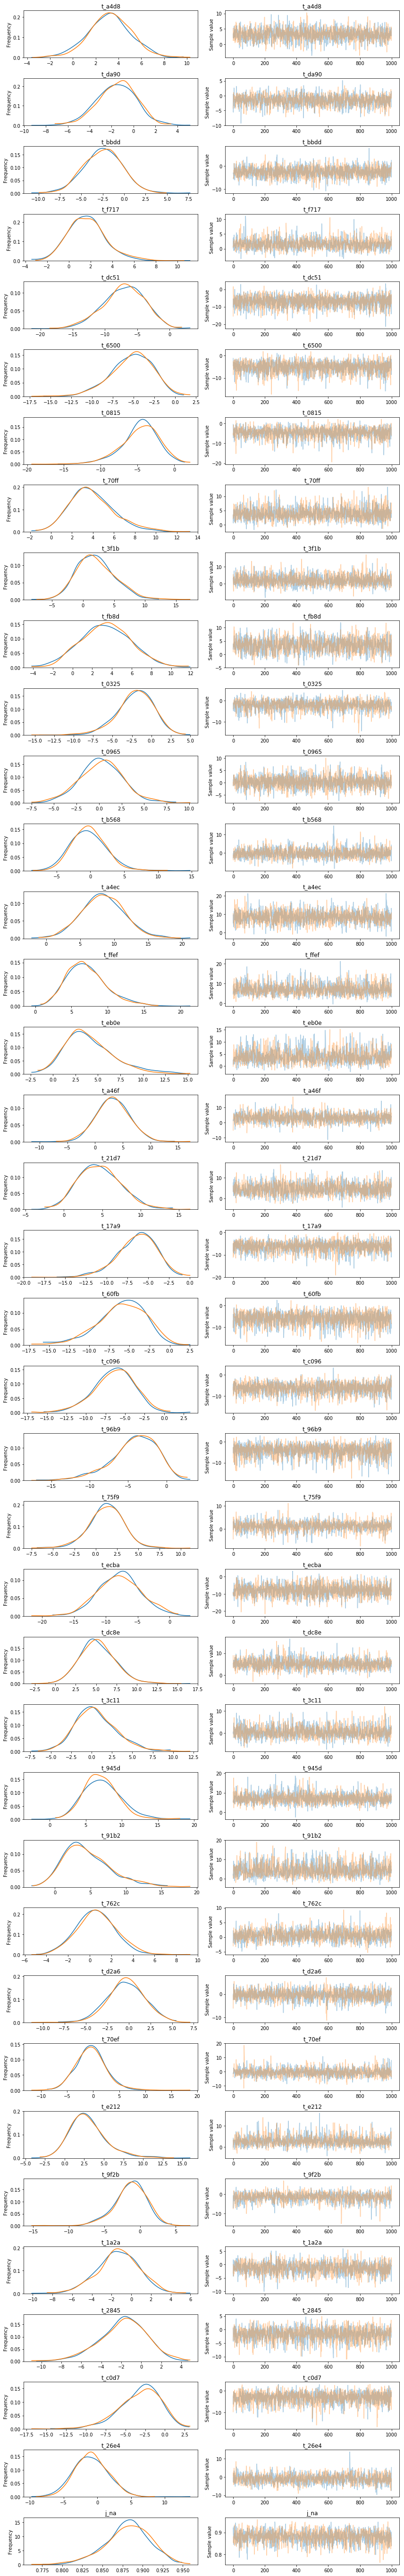

In [63]:
## Compute posterior

with model:
    trace = pm.sample(1000, tune=300)
    
pm.traceplot(trace);

/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/mini

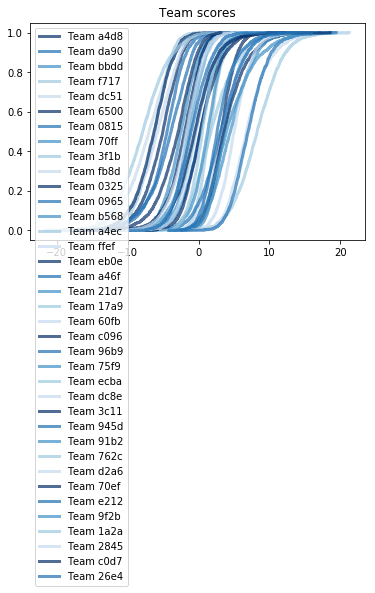

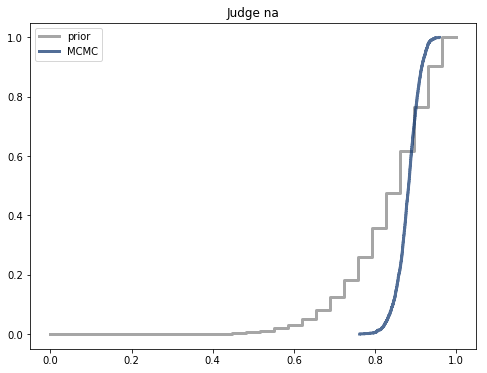

<Figure size 576x432 with 0 Axes>

In [71]:
for i in teams:
    thinkplot.Cdf(Cdf(trace[f"t_{i}"]), label=f'Team {i}')
    thinkplot.Config(title=f"Team scores")
thinkplot.Show()

for i in judges:
    thinkplot.Cdf(judge_prior.MakeCdf(), color='grey', label='prior')
    thinkplot.Cdf(Cdf(trace[f"j_{i}"]), label='MCMC')
    thinkplot.Config(title=f"Judge {i}")
    thinkplot.Show()

## Analyzing tournament results

Using this trace, we can analyze the results of the tournament to determine which team is probably the best, and with what probability. Because there exists cross-correlation between the scores of the different teams, we do this by computing the winner separately for each trace in the MCMC output, then count how frequently each team wins.

In [65]:
def compute_winners(trace):
    teams = [n for n in trace.varnames if n.startswith('t_')]
    winners = []
    for i in range(len(trace)):
        winners.append(max(teams, key=lambda team: trace[team][i]))
    return winners

winners = compute_winners(trace)

In [73]:
from collections import Counter

for team, count in Counter(winners).most_common():
    # Ignore teams with very few wins
    if count > 5:
        print(f"Team {team} is best with probability {count/len(trace)*100:.1f}%")

Team t_a4ec is best with probability 38.8%
Team t_ffef is best with probability 19.5%
Team t_945d is best with probability 15.4%
Team t_91b2 is best with probability 8.5%
Team t_eb0e is best with probability 5.6%
Team t_dc8e is best with probability 2.9%
Team t_21d7 is best with probability 2.8%
Team t_a46f is best with probability 2.2%
Team t_70ff is best with probability 1.6%
Team t_e212 is best with probability 0.9%


This result indicates that, even though one team comes out "on top", **the available judging data is insufficient to demonstrate that they are actually the winner**. To the contrary, this result indicates that there is a 60% chance they are _not_ the best team. 

Despite that, the algorithm is doing a remarkably good job of extracting expectations of true team goodness from the noisy judge rankings available. It also concludes that judges are about 90% reliable, although the data here is insufficient to properly utilize that information between multiple judges.